# Imports

In [1]:
import pandas as pd
import numpy as np
import findspark
findspark.init()

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import DataFrame

In [4]:
from pyspark.ml.feature import StandardScaler

In [5]:
from pyspark.sql import SparkSession
import findspark
findspark.init()
spark = SparkSession.builder\
    .getOrCreate()

# Get data: breast_cancer

In [7]:
# Here we are using inbuilt dataset of scikit learn
from sklearn.datasets import load_breast_cancer

# instantiating
cancer = load_breast_cancer(as_frame=True)

cancer_df = cancer.frame

In [8]:
df = spark.createDataFrame(data = cancer_df)

In [10]:
df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|target|
+-----------

In [11]:
len(df.columns)

31

# PCA

In [12]:
from pyspark.ml.feature import VectorAssembler

In [13]:
from pyspark.ml.feature import PCA
assembler = VectorAssembler(inputCols=[col for col in
df.columns if col !='target'], outputCol="features")

In [14]:
df_new = assembler.transform(df)

In [15]:
df_new.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension

In [16]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")

pca_model = pca.fit(df_new)

pca_df = pca_model.transform(df_new)

# Standardize the feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_new)
df_new = scaler_model.transform(df_new)

pca_comp = pca_df.select("pca_features")

pca_comp.show(truncate=False)

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[-2260.01388629254,-187.96030122263633]  |
|[-2368.9937557820535,121.58742425815576] |
|[-2095.6652015478603,145.113985658702]   |
|[-692.6905100570506,38.576922592081935]  |
|[-2030.2124927427055,295.2979839927931]  |
|[-888.2800535760758,26.079796157025896]  |
|[-1921.0822124748443,58.80757247309989]  |
|[-1074.7813350047957,31.771227808469952] |
|[-908.5784781618827,63.83075279044658]   |
|[-861.5784494075676,40.57073549705355]   |
|[-1404.5591306499468,88.23218257736282]  |
|[-1524.2324408687812,-3.263057316777638] |
|[-1734.3856477464146,273.16267815114645] |
|[-1162.9140032230353,217.63481808344642] |
|[-903.430103049883,135.61517666084816]   |
|[-1155.8759954206846,76.80889383742199]  |
|[-1335.7294321308063,-2.4684005450352613]|
|[-1547.2640922523085,3.8056759725747797] |
|[-2714.964765181215,-164.37610864258735] |
|[-908.2502671870873,118.2164200

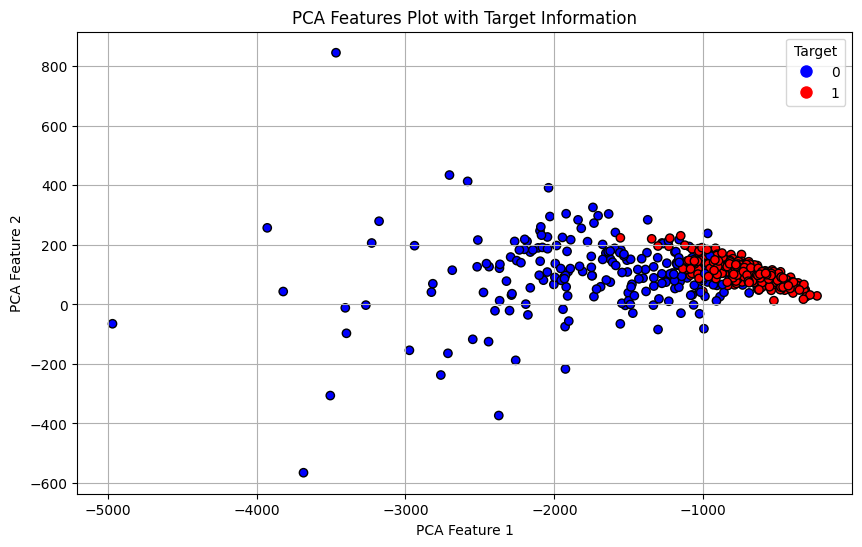

In [17]:
# Assuming 'pca_features' and 'target' are the columns in your DataFrame
pandas_df = pca_model.transform(df_new).select("pca_features", "target").toPandas()

# Extract the PCA features and target values from the Pandas DataFrame
pca_features = pandas_df['pca_features'].tolist()
targets = pandas_df['target'].tolist()

# Split the PCA features into two separate lists (for x and y coordinates)
x_values = [item[0] for item in pca_features]
y_values = [item[1] for item in pca_features]

# Create a dictionary to map unique target values to colors
color_mapping = {
    0: 'blue',
    1: 'red',
    # Add more target values and corresponding colors as needed
}

# Create a list of colors for each data point based on the target values
colors = [color_mapping[target] for target in targets]

# Create a scatter plot with different colors for each target category
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, c=colors, marker='o', edgecolor='black')

# Add labels and title
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Features Plot with Target Information')

# Create a legend based on the color mapping
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=target) for target, color in color_mapping.items()]
plt.legend(handles=legend_labels, title='Target')

# Show the plot
plt.grid(True)
plt.show()

# How to choose number of components?

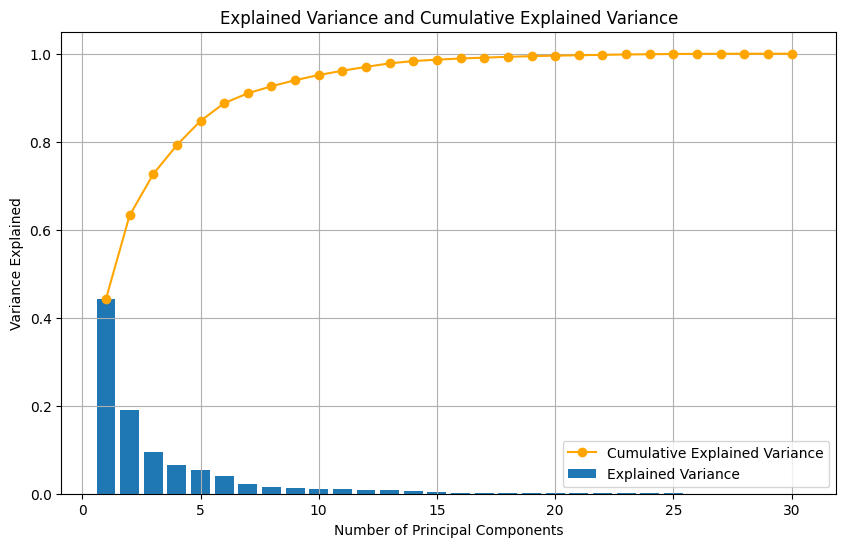

In [19]:
# Create a Spark session
spark = SparkSession.builder.appName("PCAExplainedVariancePlot").getOrCreate()

# Assuming you have a DataFrame named 'data' with your feature columns and a 'target' column
data = spark.createDataFrame(data = cancer_df)

# Assemble the feature vectors into a single column 'features'
feature_columns = data.columns
feature_columns.remove('target')  # Exclude the target column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = vector_assembler.transform(data)

# Standardize the feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Perform PCA
pca = PCA(k=len(feature_columns), inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(data)

# Extract the explained variance ratios
explained_variance = model.explainedVariance.toArray()

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, label='Explained Variance')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='orange', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance and Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()


# Another example

In [ ]:
from pyspark.sql import Row

# Create a Spark session
spark = SparkSession.builder.appName("TwoColumnDataFrame").getOrCreate()

# Create a list of Row objects with two columns
data = [
    Row(column1=4, column2=11),
    Row(column1=8, column2=4),
    Row(column1=13, column2=5),
    Row(column1=7, column2=14)
]

# Create an RDD from the list of Row objects
rdd = spark.sparkContext.parallelize(data)

# Create a DataFrame from the RDD
df_2 = spark.createDataFrame(rdd)

# Show the DataFrame
df_2.show()

+-------+-------+
|column1|column2|
+-------+-------+
|      4|     11|
|      8|      4|
|     13|      5|
|      7|     14|
+-------+-------+



In [ ]:
assembler_2 = VectorAssembler(inputCols=[col for col in
df_2.columns], outputCol="features")

In [ ]:
df_new_2 = assembler_2.transform(df_2)

In [ ]:
# Standardize the feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_new_2)
df_new_2 = scaler_model.transform(df_new_2)

In [ ]:
pca = PCA(k=1, inputCol="features", outputCol="pca_features")

pca_model_2 = pca.fit(df_new_2)

pca_df_2 = pca_model_2.transform(df_new_2)

pca_comp_2 = pca_df_2.select("pca_features")

pca_comp_2.show(truncate=False)

+---------------------+
|pca_features         |
+---------------------+
|[6.903199137159284]  |
|[-1.1381164721267525]|
|[-3.094815496076416] |
|[7.721781688982196]  |
+---------------------+

